# Module 03: Assignment for 1-D Diffusion Problem - Thawing Permafrost
By: Michael Chiwere
### 1. Introduction and Background

In this notebook you are going to investigate the impact of three climate change scenarios on our previously developed model of the vertical distribution of temperature in a permafrost soil. 


Again, the equation for 1-dimensional heat diffusion into a soil is presented below:
$$
\rho_s \cdot C_s \cdot \frac{\partial T_s}{\partial t} = \frac{\partial T_s}{\partial z}\left(k_s \cdot \frac{\partial T_s}{\partial z}\right)
$$

where $\rho_s$ (kg/m^3) is the bulk density of the soil, $C_s$ (J/(kg K)) is the heat capacity of the soil, $k_s$ (W/(m K)) is the thermal conductivity of the soil, $T_s$ is the temperature of the soil at some time $t$ and depth in the soil $z$. For the sake of simplicity, we're going to assume that the thermal conductivity is constant. This assumption is not strictly true, as $k_s$ changes with the amount and phase (frozen or liquid) of water in the soil. But it makes the math much simpler and is good starting point for a toy model. Under this assumption we can simplify the above equation to,

$$
\rho_s \cdot C_s \cdot \frac{\partial T_s}{\partial t} = k_s \frac{\partial T_s^2}{\partial^2 z}
$$

Going further, if we also assume that the bulk density ($rho_s$) and heat capacity ($C_s$) are constant, then we can combine them with the thermal conductivity and reduce them to a single parameter that is often referred to as the _thermal diffusivity_ ($D_s$) and has dimensions of m^2/s, 

$$
D_s = \frac{k_s}{\rho_s \cdot C_s}
$$

Substituting into the above, we obtain the following governing equation that our model will solve, 

$$
\frac{\partial T_s}{\partial t} = D_s \frac{\partial T_s^2}{\partial^2 z}
$$

Your __top boundary condition__, we will assume sinusoidal forcing of air temperature superimposed on a linear trend in mean annual temperatures at the surface, with a period of one year. In this notebook we will explore three scenarios. Scenario 1 is a linear increase in mean annual temperature at a rate that results in 1.5 °C of warming by 2100. Scenario 2 is a linear increase in mean annual temperature at a rate that results in 3.0 °C of warming by 2100. Scenario 3 is a linear increase in mean annual temperature at a rate that results in 4.5 °C of warming by 2100. We will start all simulations in 2020. 

Your __bottom boundary condition__, we will assume a constant temperature at the initial mean annual air temperature. 

Yur __initial condition__ will be a constant temperature (isothermal) at the mean annual air temperature. If interested you can copy this notebook and modify these values.

### 2. Initial Setup

Below, we set the values for our spatial domain, simulation period, soil properties, and boundary conditions. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Soil column properties
zs = 500.0 # Depth of soil [cm]
dz = 15.0   # Numerical model layer thickness [cm]

# Soil properties (obtained from https://doi.org/10.1029/2017JF004535)
Cs = 635.0 # Heat capacity of soil/permafrost [J/(kg K)]
ks = 0.25  # Thermal conductivity of soil/permafrost [W/(m K)]
rhos = 920.0 # Bulk density of permafrost [kg/m^3] 

dt = 0.25 # Time step [day]

#### 2.1 Load and Plot the Air Temperature Trends

In [2]:
data = np.loadtxt('PermafrostTemperatureScenarios.csv', delimiter=',', skiprows=1)

t_year = data[:,0]
T_15 = data[:,1]
T_30 = data[:,2]
T_45 = data[:,3]

Text(0, 0.5, 'Annual average air temperature [°C]')

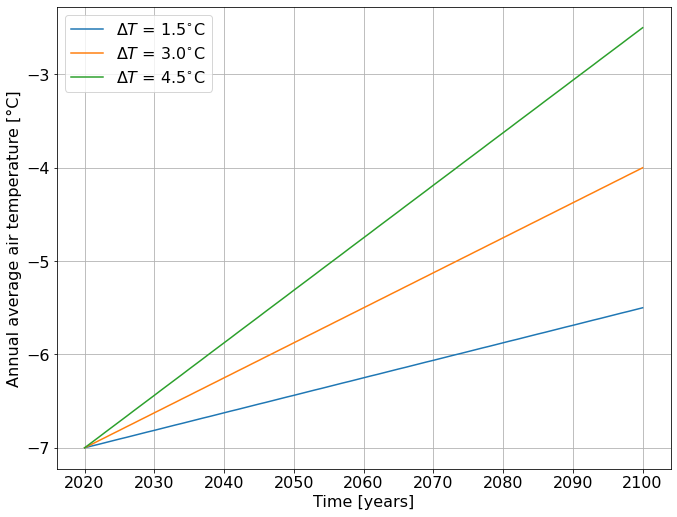

In [3]:
## First off, let's change the font size for all of our plots to be more legible
plt.rcParams.update({'font.size': 16})

plt.figure(figsize=(11.0,8.5))
plt.plot(t_year,T_15,label='$\Delta T$ = 1.5${}^{\circ}$C')
plt.plot(t_year,T_30,label='$\Delta T$ = 3.0${}^{\circ}$C')
plt.plot(t_year,T_45,label='$\Delta T$ = 4.5${}^{\circ}$C')
plt.legend(loc='upper left')
plt.grid()
plt.xlabel('Time [years]')
plt.ylabel('Annual average air temperature [°C]')


#### 2.2 Setup the Simulation Time Period

In [4]:
# Time properties of simulation
t0 = t_year[0]
tf = t_year[-1]
c = int(tf-t0);
t = np.arange(t0,tf+(dt/365),(dt/365))
#t = np.linspace(t0,tf,365*4*c)
Nt = t.size
print('The number of time steps: Nt = ',str(Nt))

The number of time steps: Nt =  116801


### 3. Setup Boundary Conditions

In [5]:
# Boundary conditions
Ttopamp = 35.0
Tbottom = -7.0

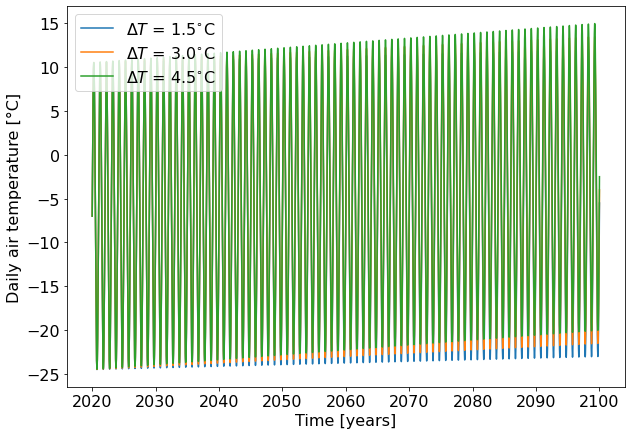

In [6]:
Ttop_15 = np.interp(t, t_year, T_15) + (Ttopamp/2.0)*np.sin((2.0*np.pi)*t)
Ttop_30 = np.interp(t, t_year, T_30) + (Ttopamp/2.0)*np.sin((2.0*np.pi)*t)
Ttop_45 = np.interp(t, t_year, T_45) + (Ttopamp/2.0)*np.sin((2.0*np.pi)*t)

plt.figure(figsize=(10.0,7.0))
plt.plot(t, Ttop_15, label='$\Delta T$ = 1.5${}^{\circ}$C')
plt.plot(t, Ttop_30, label='$\Delta T$ = 3.0${}^{\circ}$C')
plt.plot(t, Ttop_45, label='$\Delta T$ = 4.5${}^{\circ}$C')
plt.xlabel('Time [years]')
plt.ylabel('Daily air temperature [°C]')
plt.legend(loc='upper left')
plt.show()

### 4. Setup Spatial Domain

In [7]:
z = np.arange(dz/2,zs,dz);
Nz = z.size;


### 5. Setup Initial Condition

In [8]:
Ts0 = Tbottom * np.ones((Nz,1));

### 6. Calculate $D$, and $\mathbf{A}$ Matrix for Implicit 

In [9]:
# Computing D
Ds = (ks/(rhos * Cs) )* (100**2) * (24.0 * 3600.0);
alpha = Ds*dt/(2*dz**2);

# Computing toeplitz matrix  D
      
D = np.diag(-2.0*np.ones((Nz))) + np.diag(np.ones((Nz-1)),1) + np.diag(np.ones((Nz-1)),-1);

# coeffient matrix A
A = np.eye(Nz) - alpha * D;
A[0,:] = np.hstack((1.0,np.zeros((Nz-1))))
A[-1,:] = np.hstack((np.zeros((Nz-1)),1.0))

# compute  A inverse

A_inv = np.linalg.pinv(A);
alpha

0.20540910647038682

### 7. Preallocate Storage for Soil Temperatures

In [10]:
Ts_15 = np.zeros((Nz,Nt));
Ts_30 = np.zeros((Nz,Nt));
Ts_45 = np.zeros((Nz,Nt));

### 8. Apply Solution And Compute Temperatures

In [11]:

for i in np.arange(Nt):
    if(i==0):
        Tsi_15 = Ts0;
        Tsi_30 = Ts0;
        Tsi_45 = Ts0;
    else:
        Tsi_15 = Ts_15[:,i-1];
        Tsi_30 = Ts_30[:,i-1];
        Tsi_45 = Ts_45[:,i-1];
        
        Tsi_15[0] = Ttop_15[i];
        Tsi_30[0] = Ttop_30[i];
        Tsi_45[0] = Ttop_45[i];
        
        Tsi_15[-1] = Tbottom;
        Tsi_30[-1] = Tbottom;
        Tsi_45[-1] = Tbottom;
        
        T_15 = np.matmul(A_inv,Tsi_15);
        T_30 = np.matmul(A_inv,Tsi_30);
        T_45 = np.matmul(A_inv,Tsi_45);
        
        Ts_15[:,i] = np.squeeze(T_15);
        Ts_30[:,i] = np.squeeze(T_30);
        Ts_45[:,i] = np.squeeze(T_45);
        
        
        

In [12]:
# Grid first 10 years
k1 = 10*365*4+1;
t1 = t[1:k1];
tt1,zz1 = np.meshgrid(t1,z);
# grid last 10 years
t2=t[Nt-k1-1:];
tt2,zz2 = np.meshgrid(t2,z);

# 9. Plot Results, Analyze, and Interpret

Create plots of the following:

1. A plot of 3 x 2 subplots of the vertical temperature distribution with time. Each row should correspond to each of the 3 climate change scenarios wiht the top row being the $\Delta T$ = 1.5${}^{\circ}$C, the middle being $\Delta T$ = 3.0${}^{\circ}$C, and the bottom row being $\Delta T$ = 4.5${}^{\circ}$C. The left column should correspond to the ___first___ 10 years of simulation, and the right column the ___last___ 10 years of simulation.
2. A plot of 2 x 2 subplots of the temperature at four different levels. One subplot of temperature versus time for all three scenarios at a depth of 50 cm, the second subplot the same information at 100 cm, the third subplot the same information at 200 cm, and the fourth subplot the same information at 400 cm. 
3. A markdown table showing the approximate depth of the active layer for each scenario for the first, a middle, and the final decade of the simulation.  

__1. A plot of $3\times 2$ sublots of the vertical temperature distribution with time.__

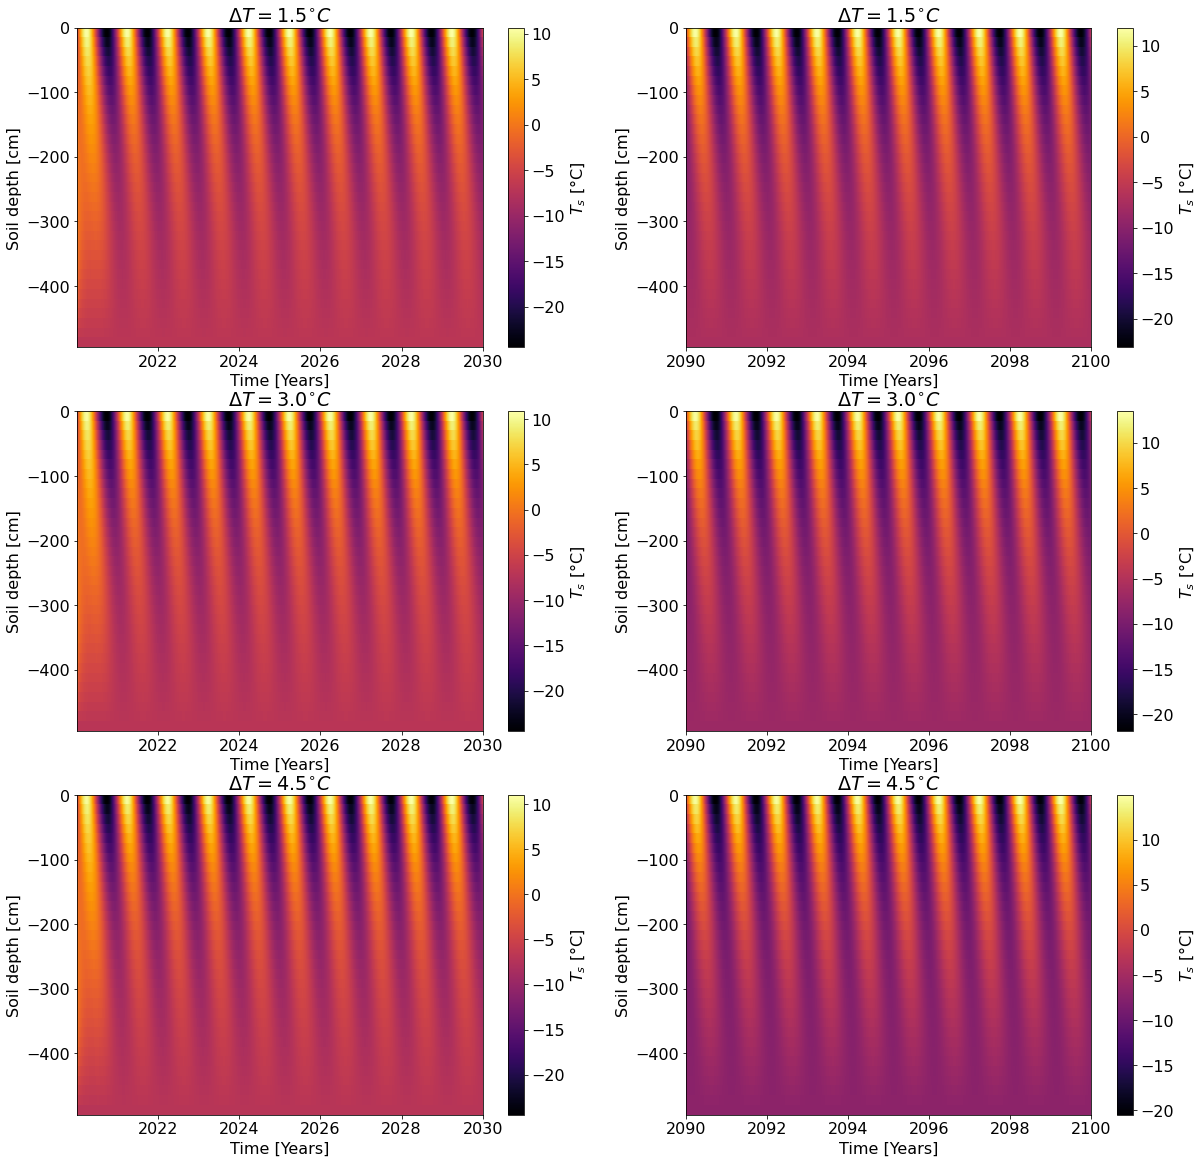

In [13]:

fig, axs = plt.subplots(3, 2, figsize=(20,20))
a1=axs[0, 0].pcolormesh(tt1, -zz1, Ts_15[:,1:k1], cmap = 'inferno',shading='auto')
axs[0, 0].set_title(r'$\Delta T = 1.5^{\circ} C$')
ax = axs[0,0]
fig.colorbar(a1, ax=ax, label='$T_s$ [°C]')

a2=axs[0, 1].pcolormesh(tt2, -zz2, Ts_15[:,Nt-k1-1:], cmap = 'inferno',shading='auto')
axs[0, 1].set_title(r'$\Delta T = 1.5^{\circ} C$')
ax = axs[0,1]
fig.colorbar(a2, ax=ax, label='$T_s$ [°C]')


b=axs[1, 0].pcolormesh(tt1, -zz1, Ts_30[:,1:k1], cmap = 'inferno',shading='auto')
axs[1, 0].set_title(r'$\Delta T = 3.0^{\circ} C$')
ax = axs[1,0]
fig.colorbar(b, ax=ax, label='$T_s$ [°C]')

a3=axs[1, 1].pcolormesh(tt2, -zz2, Ts_30[:,Nt-k1-1:], cmap = 'inferno',shading='auto')
axs[1, 1].set_title(r'$\Delta T = 3.0^{\circ} C$')
ax = axs[1,1]
fig.colorbar(a3, ax=ax, label='$T_s$ [°C]')

a4=axs[2, 0].pcolormesh(tt1, -zz1, Ts_45[:,1:k1], cmap = 'inferno',shading='auto')
axs[2, 0].set_title(r'$\Delta T = 4.5^{\circ} C$')
ax = axs[2,0]
fig.colorbar(a4, ax=ax, label='$T_s$ [°C]')

a5=axs[2, 1].pcolormesh(tt2, -zz2, Ts_45[:,Nt-k1-1:], cmap = 'inferno',shading='auto')
axs[2, 1].set_title(r'$\Delta T = 4.5^{\circ} C$')
ax = axs[2,1]
fig.colorbar(a5, ax=ax, label='$T_s$ [°C]')

for ax in axs.flat:
    ax.set(xlabel='Time [Years]', ylabel='Soil depth [cm]')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
plt.show()

We notice  that the temperatures are higher in the last decade as compared to the first decade in all scenarios, and this change is more pronounced for the $\Delta T = 4.5^{\circ}$ case.

__2. A plot of $2\times 2$ subplots of temperature at four different levels.__

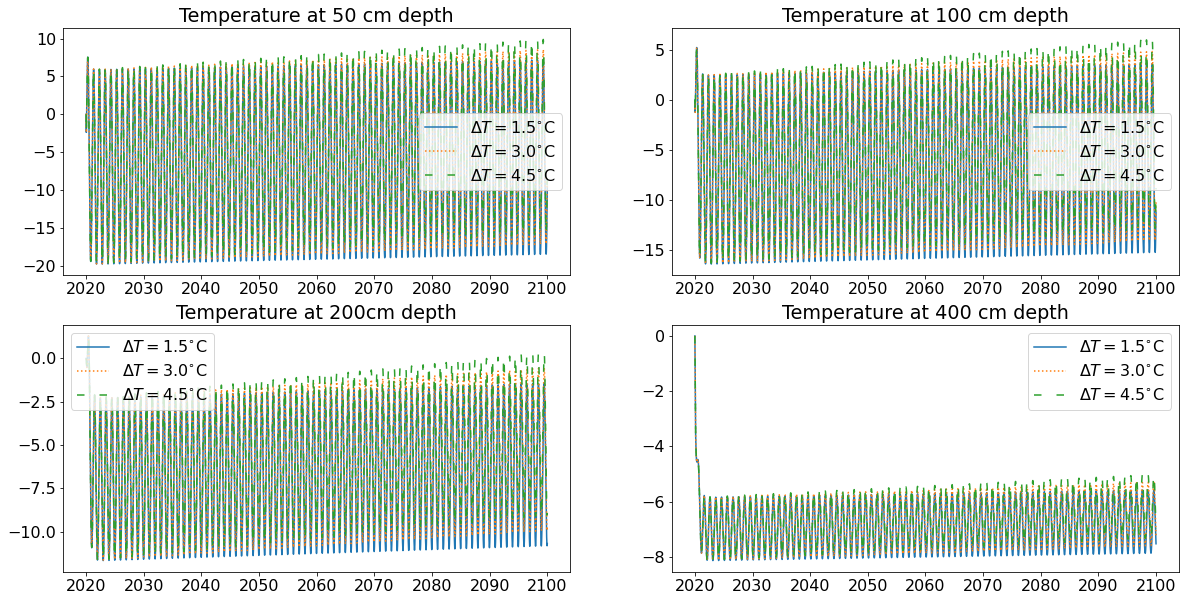

In [14]:
# computing the closest row to 50cm, 100cm, 200 and 400cm
iz50 = (np.absolute(z-50.0)).argmin();
iz100 = (np.absolute(z-100.0)).argmin();
iz200 = (np.absolute(z-200.0)).argmin();
iz400 = (np.absolute(z-400.0)).argmin();

# plotting the subplots

fig, ax = plt.subplots(2, 2, figsize = (20, 10))
ax[0,0].plot(t, Ts_15[iz50,:], label = r'$\Delta T = 1.5^{\circ}$C');
ax[0,0].plot(t, Ts_30[iz50,:], label = r'$\Delta T = 3.0^{\circ}$C', linestyle = 'dotted');
ax[0,0].plot(t, Ts_45[iz50,:], label = r'$\Delta T = 4.5 ^{\circ}$C', linestyle = (0,(5,10)));
ax[0,0].set_title('Temperature at 50 cm depth');
ax[0,0].legend();

ax[0,1].plot(t, Ts_15[iz100,:], label = r'$\Delta T = 1.5^{\circ}$C');
ax[0,1].plot(t, Ts_30[iz100,:], label = r'$\Delta T = 3.0^{\circ}$C', linestyle = 'dotted');
ax[0,1].plot(t, Ts_45[iz100,:], label = r'$\Delta T = 4.5^{\circ}$C', linestyle = (0,(5,10)));
ax[0,1].set_title('Temperature at 100 cm depth');
ax[0,1].legend();

ax[1,0].plot(t, Ts_15[iz200,:], label = r'$\Delta T = 1.5^{\circ}$C');
ax[1,0].plot(t, Ts_30[iz200, :], label = r'$\Delta T = 3.0^{\circ}$C', linestyle = 'dotted');
ax[1,0].plot(t, Ts_45[iz200, :], label = r'$\Delta T = 4.5^{\circ}$C', linestyle = (0,(5,10)));
ax[1,0].set_title('Temperature at 200cm depth');
ax[1,0].legend();

ax[1,1].plot(t, Ts_15[iz400,:], label = r'$\Delta T = 1.5^{\circ}$C');
ax[1,1].plot(t, Ts_30[iz400, :], label = r'$\Delta T = 3.0^{\circ}$C', linestyle = 'dotted');
ax[1,1].plot(t, Ts_45[iz400, :], label = r'$\Delta T = 4.5^{\circ}$C', linestyle = (0,(5,10)));
ax[1,1].set_title("Temperature at 400 cm depth");
ax[1,1].legend();


for ax in axs.flat:
    ax.set(xlabel='Time [Years]', ylabel='Soil Temperature [°C]')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
plt.show()


In all scenarios temperature have a widest range and reaches the peak at 50 cm. We observe that temperatures all levels are experiencing linear increases, with the $\Delta T = 4.5^{\circ}C$ 
being responsible for the greatest increase, and the $\Delta T = 1.5 ^{\circ}$ being responsible for the slowest increase.

__3. A markdown table showing the approximate depth of the active layer for each scenario for the first, a middle, and the final decade of the simulation.__

<ipython-input-15-3256a98afbf1>:25: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("inferno"))
  current_cmap.set_bad(color='blue')


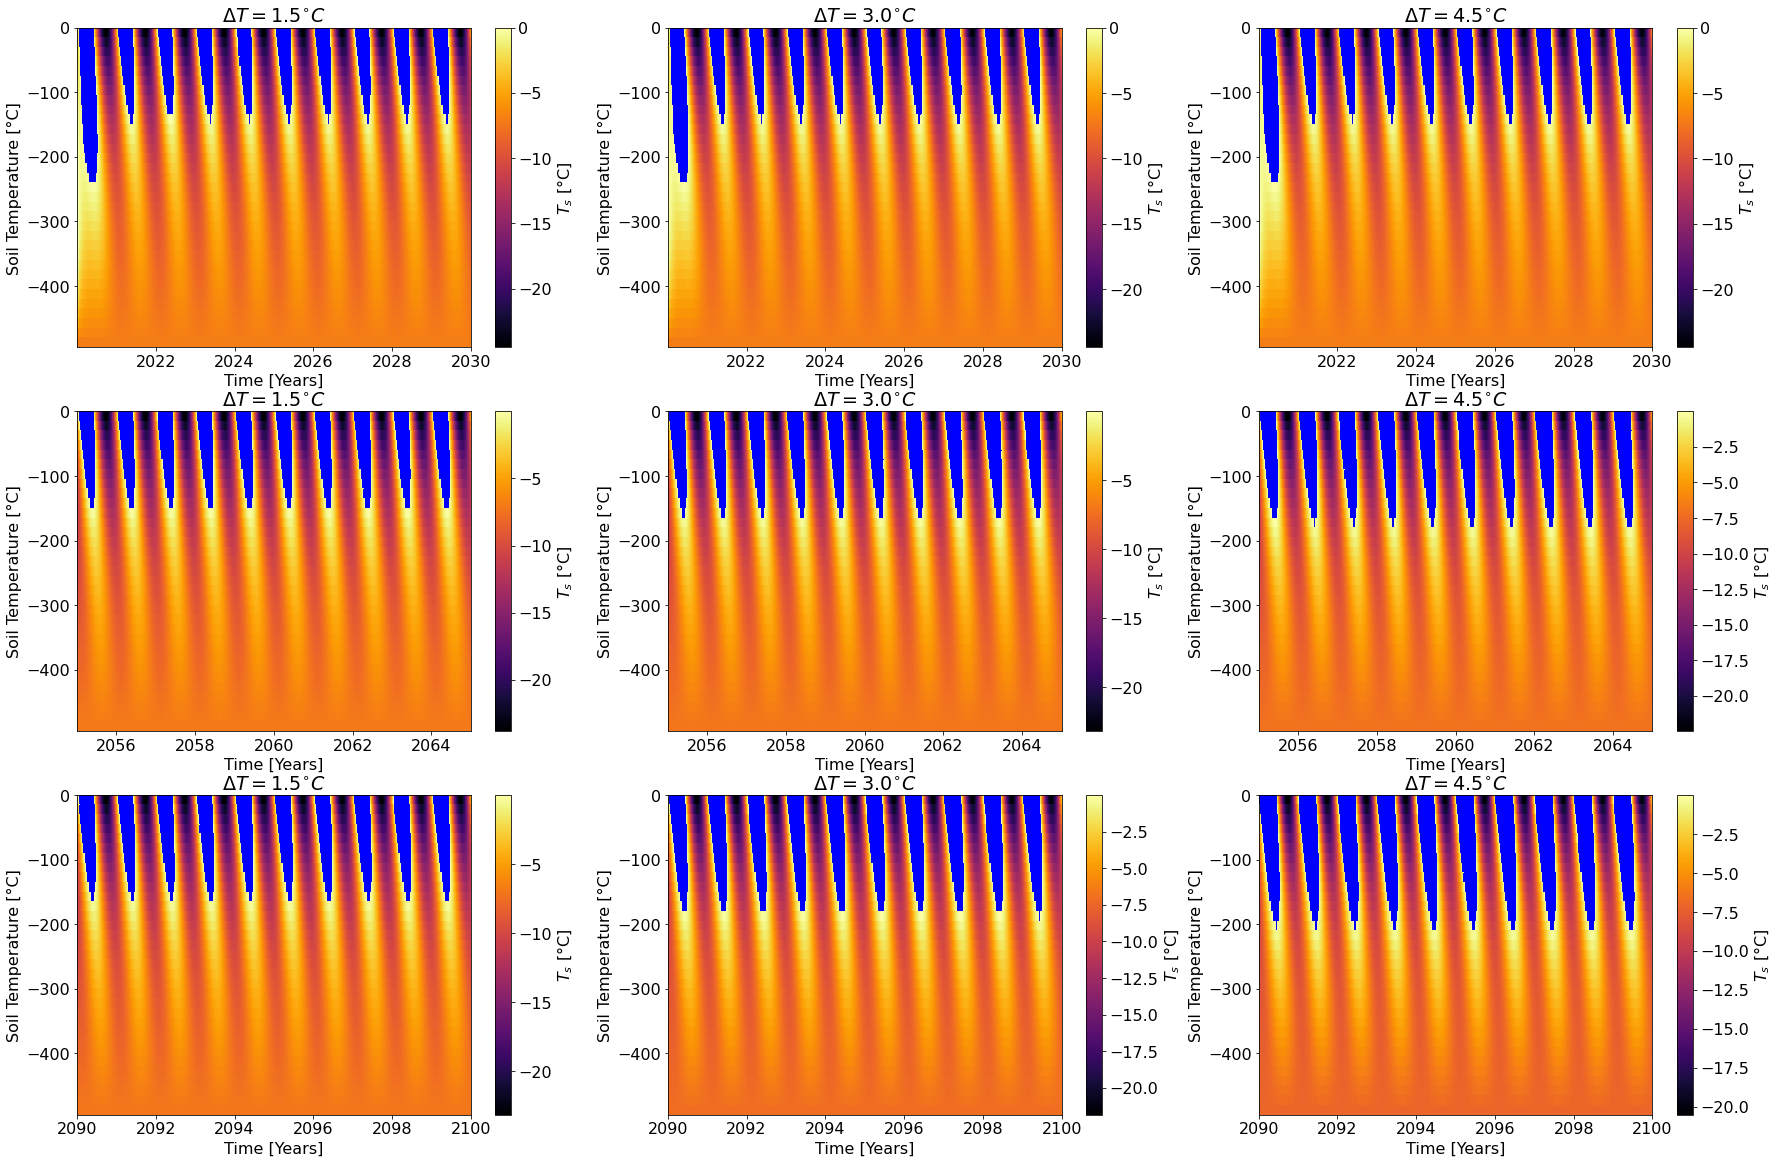

In [15]:
# Plots in each row are for each decade
# first-decade
Ts_frozen15 = np.ma.masked_where(Ts_15[:,1:k1]>0.0,Ts_15[:,1:k1])
Ts_frozen30 = np.ma.masked_where(Ts_30[:,1:k1]>0.0,Ts_30[:,1:k1])
Ts_frozen45 = np.ma.masked_where(Ts_45[:,1:k1]>0.0,Ts_45[:,1:k1])

# mid decade 2055-2065
k2 = 35*4*365+1;
k3 = 45*4*365+1;
ttm,zzm = np.meshgrid(t[k2:k3],z);
Ts_frozen15m = np.ma.masked_where(Ts_15[:,k2:k3]>0.0,Ts_15[:,k2:k3])
Ts_frozen30m = np.ma.masked_where(Ts_30[:,k2:k3]>0.0,Ts_30[:,k2:k3])
Ts_frozen45m = np.ma.masked_where(Ts_45[:,k2:k3]>0.0,Ts_45[:,k2:k3])

# final decade
Ts_frozen15l = np.ma.masked_where(Ts_15[:,Nt-k1-1:]>0.0,Ts_15[:,Nt-k1-1:])
Ts_frozen30l = np.ma.masked_where(Ts_30[:,Nt-k1-1:]>0.0,Ts_30[:,Nt-k1-1:])
Ts_frozen45l = np.ma.masked_where(Ts_45[:,Nt-k1-1:]>0.0,Ts_45[:,Nt-k1-1:])



fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(30, 20))
#first decade
current_cmap = plt.cm.get_cmap('inferno')
current_cmap.set_bad(color='blue')
a1=axs[0,0].pcolormesh(tt1,-zz1,Ts_frozen15,cmap=current_cmap, shading='auto')
axs[0, 0].set_title(r'$\Delta T = 1.5^{\circ} C$')
ax = axs[0,0]
fig.colorbar(a1, ax=ax, label='$T_s$ [°C]')

a2=axs[0,1].pcolormesh(tt1,-zz1,Ts_frozen30,cmap=current_cmap, shading='auto')
axs[0, 1].set_title(r'$\Delta T = 3.0^{\circ} C$')
ax = axs[0,1]
fig.colorbar(a2, ax=ax, label='$T_s$ [°C]')


a3=axs[0,2].pcolormesh(tt1,-zz1,Ts_frozen45,cmap=current_cmap, shading='auto')
axs[0, 2].set_title(r'$\Delta T = 4.5^{\circ} C$')
ax = axs[0,2]
fig.colorbar(a3, ax=ax, label='$T_s$ [°C]')

# mid decade
a4=axs[1,0].pcolormesh(ttm,-zzm,Ts_frozen15m,cmap=current_cmap, shading='auto')
axs[1, 0].set_title(r'$\Delta T = 1.5^{\circ} C$')
ax = axs[1,0]
fig.colorbar(a4, ax=ax, label='$T_s$ [°C]')

a5=axs[1,1].pcolormesh(ttm,-zzm,Ts_frozen30m,cmap=current_cmap, shading='auto')
axs[1, 1].set_title(r'$\Delta T = 3.0^{\circ} C$')
ax = axs[1,1]
fig.colorbar(a5, ax=ax, label='$T_s$ [°C]')


a6=axs[1,2].pcolormesh(ttm,-zzm,Ts_frozen45m,cmap=current_cmap, shading='auto')
axs[1, 2].set_title(r'$\Delta T = 4.5^{\circ} C$')
ax = axs[1,2]
fig.colorbar(a6, ax=ax, label='$T_s$ [°C]')

# last decade
a7=axs[2,0].pcolormesh(tt2,-zz2,Ts_frozen15l,cmap=current_cmap, shading='auto')
axs[2, 0].set_title(r'$\Delta T = 1.5^{\circ} C$')
ax = axs[2,0]
fig.colorbar(a7, ax=ax, label='$T_s$ [°C]')

a8=axs[2,1].pcolormesh(tt2,-zz2,Ts_frozen30l,cmap=current_cmap, shading='auto')
axs[2, 1].set_title(r'$\Delta T = 3.0^{\circ} C$')
ax = axs[2,1]
fig.colorbar(a8, ax=ax, label='$T_s$ [°C]')


a9=axs[2,2].pcolormesh(tt2,-zz2,Ts_frozen45l,cmap=current_cmap, shading='auto')
axs[2, 2].set_title(r'$\Delta T = 4.5^{\circ} C$')
ax = axs[2,2]
fig.colorbar(a9, ax=ax, label='$T_s$ [°C]')

for ax in axs.flat:
    ax.set(xlabel='Time [Years]', ylabel='Soil Temperature [°C]')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
plt.show()


From the plot we notice that the depth of active area is generally increasing in all the three case, with $4.5^{\circ}$ rensponsible for greatest change. Also, the depth of active layer is almost the same in the first decade, but difference starts to grow big in the mid decade. We summarize the approximate depth of active layer in the following table:

Change in temperature [°C]|First decade |Mid decade | Last decade
---|---|---|---
1.5|150 cm|165cm|185 cm
3.0| 152 cm|180 cm|195 cm
4.5 |154m| 190 cm| 205 cm
